### Time Series Forecasting

#### Importing libraries, dataset and pre-processing

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# dataset downloaded from Github page of jbrownlee
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv"
)
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
# converting df to series (csv to time series)
# month into index for better data manipulation and series instead of dataframe
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv",
    index_col=[0],
    parse_dates=True,
    squeeze=True,
)
df.head()

Month
1-01    266.0
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
Name: Sales, dtype: float64

In [6]:
type(df)

pandas.core.series.Series

<AxesSubplot:xlabel='Month'>

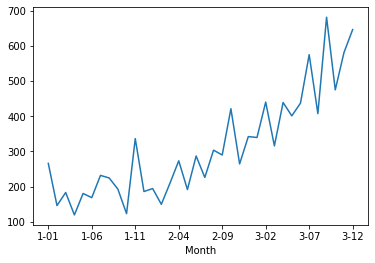

In [7]:
df.plot()

<AxesSubplot:xlabel='Month'>

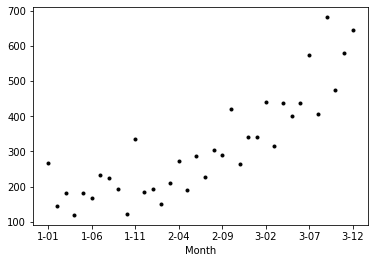

In [8]:
df.plot(style=".k")

In [9]:
df.shape

(36,)

In [10]:
df.describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Month'>

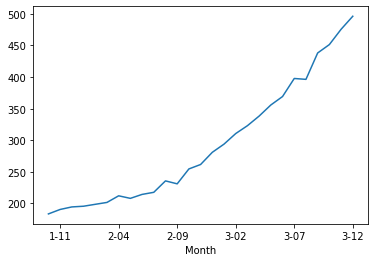

In [11]:
# smoothing the time series dataset (can be done by calculating the moving average)
# lets take 10 take moving average (mainly used in stock market analysis)
df_ma = df.rolling(window=10).mean()
df_ma.plot()

#### BaseLine model (Naive model)
It assumes that the previous values are related to the current values. In our case, the value of last day is going to reflect also the value of current day with some more variation.

In [12]:
# using shift method to create new forecast values
df_base = pd.concat([df, df.shift(1)], axis=1)
df_base.head()

,Sales,Sales
Month,,
1-01,266.0,NaN
1-02,145.9,266.0
1-03,183.1,145.9
1-04,119.3,183.1
1-05,180.3,119.3


In [13]:
# renaming the column names and removing the NaN values
df_base.columns = ["Actual_Sales", "Forecase_Sales"]
df_base.dropna(inplace=True)
print(df_base.shape)
df_base.head()

(35, 2)


,Actual_Sales,Forecase_Sales
Month,,
1-02,145.9,266.0
1-03,183.1,145.9
1-04,119.3,183.1
1-05,180.3,119.3
1-06,168.5,180.3


In [14]:
# calculate the error based on the data we create above
df_error = mean_squared_error(df_base.Actual_Sales, df_base.Forecase_Sales)
df_error = np.sqrt(df_error)
df_error

108.23764726616282

This is the error from the baseline model, lets use ARIMA model to check if we can get better results than this baseline model.

#### Auto Regressive Integrated Moving Average (ARIMA) model
- ARIMA(p,d,q) -> ARIMA takes 3 parameters
    - p -> p is Auto Regressive (p,0,0) becomes Auto Regressive model.
    - q -> q is Moving Average  (0,0,q) becomes Moving Average model.
    - So, by just playing around the p,d,q values we can create different models. But here, lets go with ARIMA model as a whole.

In [15]:
# lets calculate p with pacf and q with acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

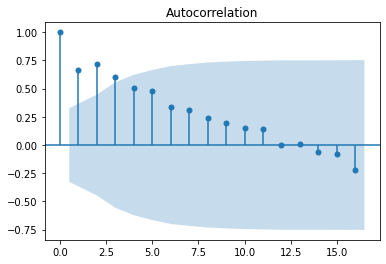

In [16]:
# very important, many people don't know this, use ; to avoid 2 graphs being plotted
# lets find q value
plot_acf(df)

Now, how to choose q value, choose the value that has corelation outside the critical range. For our case, its 3 so we take `q=3`

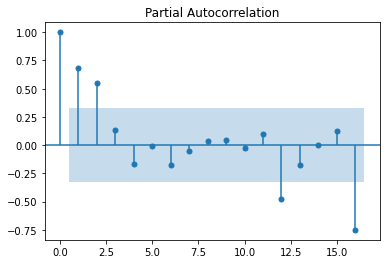

In [17]:
# now lets find p value
plot_pacf(df)

We use the same rule to choose the p value as in q, so we take `p=2`

- Now, how to find the value of d. The value of d is actually between `0-2`. 
- This value makes the series stationary by removing the trend and seasonality factor which helps for better prediciton.
- It's complicated and must read the figure if we want to calculate differencing and see the value of d. But, here lets use formula to calculate.

In [18]:
from pmdarima.arima.utils import ndiffs

ndiffs(df, test="adf")

1

Ok, so the formula gives the value as 1, so lets go with 1 for now. But if you want you can play around with this number.

We take values, `p=2`, `q=3` and `d=1`

In [19]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
# train test split (70/30)
n = int(len(df) * 0.7)
train = df[:n]
test = df[n:]
print(len(train), len(test))

25 11


In [21]:
import warnings

warnings.filterwarnings("ignore")

One strange behaviour of arima model is that i imported warnings and ignore it in the beginning but if needs to be specified again before the mdoel being initialized. proabbly it is not the case always but this time it works.

In [22]:
arima_model = ARIMA(train, order=(2, 1, 3))  # p,d,q

In [23]:
# arima_model_fit = arima_model.fit()

This error gets printed by above model fit although it follows p,d,q pattern in ARIMA model. lets change and see if it works.`ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.`

In [24]:
arima_model = ARIMA(
    train, order=(3, 1, 2)
)  # this value seems to depend upon arima dependencies so trial and error
arima_model_fit = arima_model.fit()

In [25]:
# lets see the aic value to see how good the model is, lower the better
arima_model_fit.aic

272.3891948071194

In [26]:
# forecast
df_forecast = arima_model_fit.forecast(steps=11)
df_forecast

(array([411.99808507, 364.11849745, 359.39476382, 351.27891966,
        406.97151856, 418.33293147, 411.19334147, 385.83426856,
        405.32983455, 435.87745175, 454.17130989]),
 array([45.77672156, 47.03996352, 53.77749384, 55.32955838, 66.91442454,
        68.00850486, 69.71351029, 70.41749152, 75.62881719, 79.25591984,
        81.65607574]),
 array([[322.27735948, 501.71881066],
        [271.92186312, 456.31513178],
        [253.99281271, 464.79671493],
        [242.83497796, 459.72286136],
        [275.82165642, 538.1213807 ],
        [285.03871131, 551.62715164],
        [274.55737206, 547.82931087],
        [247.81852131, 523.85001581],
        [257.10007666, 553.55959244],
        [280.5387033 , 591.21620019],
        [294.12834231, 614.21427746]]))

In [27]:
# lets take just the forecast value
df_forecast = arima_model_fit.forecast(steps=11)[
    0
]  # 0 is used to print actual forecast, as forecast contains other arrays too as shown above
df_forecast = np.round(df_forecast, 2)  # rounding to 2 decimals
df_forecast

array([412.  , 364.12, 359.39, 351.28, 406.97, 418.33, 411.19, 385.83,
       405.33, 435.88, 454.17])

In [28]:
# calculate the error
np.sqrt(mean_squared_error(test, df_forecast))

130.9284738459758

The best way to check the error is comparing it with the baseline model. If the ARIMA model gives better result than the baseline, we accept the result otherwise we reject it. So here the ARIMA model gives poor result so our base model is perfect atm.

#### Fine tuning the values
Lets fine tune the values to see if it gives better result. After fine tuning also, if the result is not good, go with base model.

In [29]:
# lets give p,d,q values of certain range
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

In [30]:
# lets search the best parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            n = int(len(df) * 0.7)
            df_train, df_test = df[:n], df[n:]
            predictions = []
            for i in range(len(df_test)):
                try:
                    model = ARIMA(df_train, order)
                    model_fit = model.fit()
                    pred = model_fit.forecast()[0]
                    predictions.append(pred)
                    error = np.sqrt(mean_squared_error(df_test, predictions))
                    print("ARIMA%s RMSE = %.2f" % (order, error))
                except:
                    continue

ARIMA(0, 0, 0) RMSE = 279.20
ARIMA(0, 0, 1) RMSE = 264.80
ARIMA(0, 0, 2) RMSE = 242.01
ARIMA(0, 0, 3) RMSE = 249.06
ARIMA(0, 0, 4) RMSE = 175.85
ARIMA(0, 1, 0) RMSE = 183.98
ARIMA(0, 1, 1) RMSE = 201.63
ARIMA(0, 1, 2) RMSE = 185.77
ARIMA(0, 1, 3) RMSE = 203.63
ARIMA(0, 1, 4) RMSE = 120.22
ARIMA(0, 2, 0) RMSE = 184.44
ARIMA(0, 2, 1) RMSE = 168.50
ARIMA(0, 2, 2) RMSE = 155.64
ARIMA(0, 2, 3) RMSE = 151.74
ARIMA(1, 0, 0) RMSE = 247.30
ARIMA(1, 0, 1) RMSE = 215.71
ARIMA(1, 0, 2) RMSE = 209.58
ARIMA(1, 0, 3) RMSE = 186.70
ARIMA(1, 1, 0) RMSE = 178.01
ARIMA(1, 1, 1) RMSE = 205.37
ARIMA(1, 2, 0) RMSE = 137.28
ARIMA(1, 2, 1) RMSE = 161.65
ARIMA(2, 0, 0) RMSE = 212.72
ARIMA(2, 0, 1) RMSE = 183.71
ARIMA(2, 0, 4) RMSE = 161.79
ARIMA(2, 1, 0) RMSE = 188.38
ARIMA(2, 1, 1) RMSE = 199.08
ARIMA(2, 1, 2) RMSE = 189.43
ARIMA(2, 2, 0) RMSE = 184.46
ARIMA(3, 0, 0) RMSE = 215.24
ARIMA(3, 0, 2) RMSE = 1650.29
ARIMA(3, 1, 0) RMSE = 148.41
ARIMA(3, 1, 1) RMSE = 151.13
ARIMA(3, 1, 2) RMSE = 134.52
ARIMA(3, 1, 4

##### same thing above can be done with itertools which makes code more clean

In [31]:
print(len(train), len(test))

25 11


In [32]:
import itertools

pdq = list(itertools.product(p_values, d_values, q_values))
for param in pdq:
    predictions = []
    for i in range(len(test)):
        try:
            model = ARIMA(train, order=param)
            model_fit = model.fit()
            pred = model_fit.forecast()[0]
            predictions.append(pred)
            error = np.sqrt(mean_squared_error(df_test, predictions))
            print("ARIMA%s RMSE = %.2f" % (param, error))
        except:
            continue

ARIMA(0, 0, 0) RMSE = 279.20
ARIMA(0, 0, 1) RMSE = 264.80
ARIMA(0, 0, 2) RMSE = 242.01
ARIMA(0, 0, 3) RMSE = 249.06
ARIMA(0, 0, 4) RMSE = 175.85
ARIMA(0, 1, 0) RMSE = 183.98
ARIMA(0, 1, 1) RMSE = 201.63
ARIMA(0, 1, 2) RMSE = 185.77
ARIMA(0, 1, 3) RMSE = 203.63
ARIMA(0, 1, 4) RMSE = 120.22
ARIMA(0, 2, 0) RMSE = 184.44
ARIMA(0, 2, 1) RMSE = 168.50
ARIMA(0, 2, 2) RMSE = 155.64
ARIMA(0, 2, 3) RMSE = 151.74
ARIMA(1, 0, 0) RMSE = 247.30
ARIMA(1, 0, 1) RMSE = 215.71
ARIMA(1, 0, 2) RMSE = 209.58
ARIMA(1, 0, 3) RMSE = 186.70
ARIMA(1, 1, 0) RMSE = 178.01
ARIMA(1, 1, 1) RMSE = 205.37
ARIMA(1, 2, 0) RMSE = 137.28
ARIMA(1, 2, 1) RMSE = 161.65
ARIMA(2, 0, 0) RMSE = 212.72
ARIMA(2, 0, 1) RMSE = 183.71
ARIMA(2, 0, 4) RMSE = 161.79
ARIMA(2, 1, 0) RMSE = 188.38
ARIMA(2, 1, 1) RMSE = 199.08
ARIMA(2, 1, 2) RMSE = 189.43
ARIMA(2, 2, 0) RMSE = 184.46
ARIMA(3, 0, 0) RMSE = 215.24
ARIMA(3, 0, 2) RMSE = 1650.29
ARIMA(3, 1, 0) RMSE = 148.41
ARIMA(3, 1, 1) RMSE = 151.13
ARIMA(3, 1, 2) RMSE = 134.52
ARIMA(3, 1, 4

##### BaseLine model has error of 108 but our ARIMA model and the tuning paramters also couldn't perform better than baseline model, so for this case going with baseline model to predict the forcasting value is better.
Some of things that could be done better.
- Use different data transformation if it helps
- Experiment with moving averages